## Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
from torch.autograd import grad as grad_torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"torch loaded; device is {device}")
torch.set_default_dtype(torch.double)
import matplotlib.pyplot as plt
import os
os.environ['CUDA_VISIBLE_DEVICES'] ='0'
import sys
sys.path.append('pytorch/')
import dolfin as df

torch loaded; device is cpu


bash: /home/lecourtier/anaconda3/envs/phifem_pytorch/lib/libtinfo.so.6: no version information available (required by bash)
bash: /home/lecourtier/anaconda3/envs/phifem_pytorch/lib/libtinfo.so.6: no version information available (required by bash)


In [3]:
import sys
sys.path.append("/home/lecourtier/Bureau/ScimBa/src")

In [4]:
from data_poisson import *
from parameters import *
x0,y0,r = domain_parameters()
use_levelset = True
new_training = False

from pathlib import Path

from scimba.nets import mlp
from scimba.pinns import domain, pinn_x, training_x
from scimba.sampling import sampling_pde, sampling_parameters, uniform_sampling

import os
current = Path(os.path.abspath(''))

Using device: cpu


## Trainer

file_path : /home/lecourtier/Bureau/these2023/test_sampling_SD/networks/laplacian_2d_levelset.pth
>> load network /home/lecourtier/Bureau/these2023/test_sampling_SD/networks/laplacian_2d_levelset.pth
network loaded successfully
self.levelset True
prior_mul <bound method Poisson2D_v2.bc_mul of <data_poisson.Poisson2D_v2 object at 0x7fdf695e70a0>>


/home/lecourtier/anaconda3/envs/phifem_pytorch/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


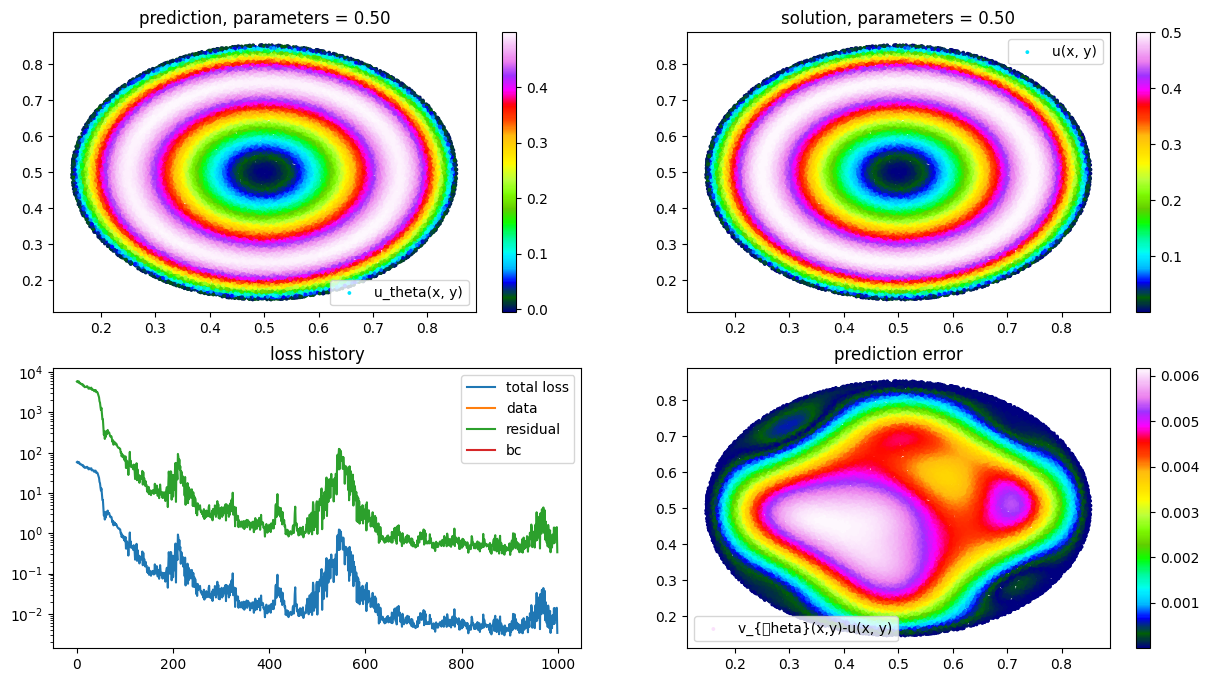

In [5]:
xdomain = domain.SignedDistanceBasedDomain(2, [[0.0, 1.0], [0.0, 1.0]], levelset)
pde = Poisson2D_v2(xdomain, use_levelset)
x_sampler = sampling_pde.XSampler(pde=pde)
mu_sampler = sampling_parameters.MuSampler(
    sampler=uniform_sampling.UniformSampling, model=pde
)
sampler = sampling_pde.PdeXCartesianSampler(x_sampler, mu_sampler)

name = "laplacian_2d"
if use_levelset:
    name += "_levelset"
name += ".pth"
file_path = current / "networks" / name
print("file_path :",file_path)
if new_training:
    file_path.unlink(missing_ok=True)

tlayers = [20, 20, 20, 20]
network = pinn_x.PINNx(
    net=mlp.GenericMLP, pde=pde, layer_sizes=tlayers, activation_type="sine"
)

trainer = training_x.TrainerPINNSpace(
    pde=pde,
    network=network,
    sampler=sampler,
    file_name=file_path,
    bc_loss_bool=not use_levelset,
    learning_rate=1.2e-2,
    decay=0.99,
    batch_size=500,
    w_data=0.0,
    w_res=0.01,
    w_bc=10.0,
)

if new_training:
    trainer.train(epochs=1000, n_collocation=500, n_bc_collocation=500, n_data=0)
trainer.plot(50000)

## Correction FEM

In [6]:
from solver import *

S,f,p = (0.5,1,0)
nb_vert = 32
solver = FEMSolver(nb_cell=nb_vert-1, params=[[S,f,p]])

In [7]:
deg_corr = 10
V_phi = FunctionSpace(solver.mesh,"CG",deg_corr)
XXYY = V_phi.tabulate_dof_coordinates()
X_test = torch.tensor(XXYY)
mu = torch.ones(XXYY.shape[0],trainer.pde.nb_parameters)*S

In [8]:
pred = trainer.network.setup_w_dict(X_test, mu)
pred
phi_tild = pred["w"][:,0].cpu().detach().numpy()
phi_tild
phi_tild_FEniCS = Function(V_phi)
phi_tild_FEniCS.vector()[np.arange(0,phi_tild.shape[0],1)] = phi_tild

self.levelset True
prior_mul <bound method Poisson2D_v2.bc_mul of <data_poisson.Poisson2D_v2 object at 0x7fdf695e70a0>>


phi_tild :


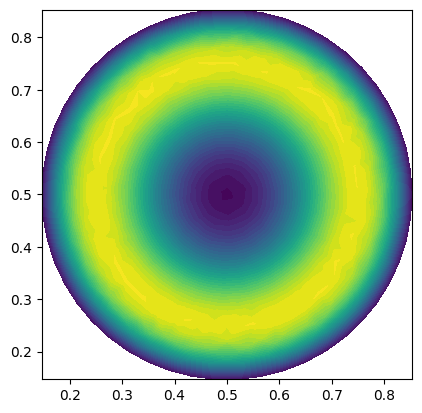

u_ex :


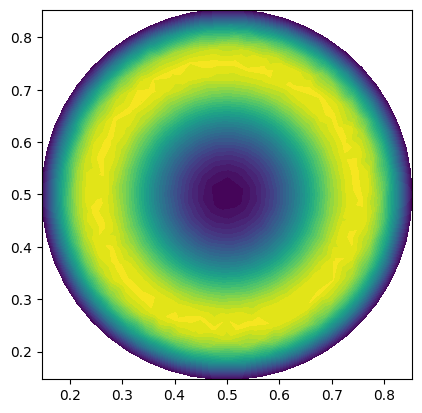

Solving linear variational problem.
C :


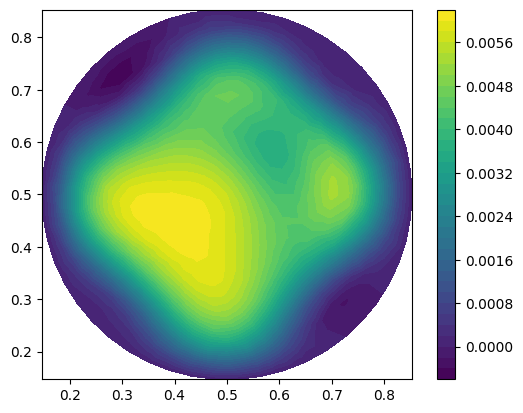

sol :
Object cannot be plotted directly, projecting to piecewise linears.


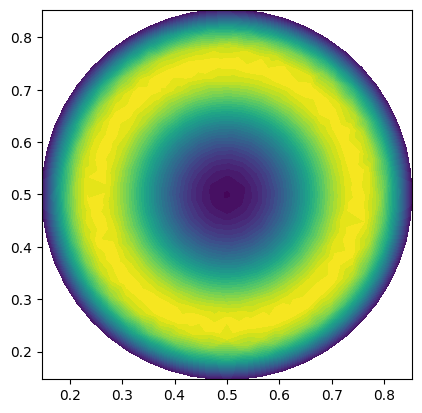

norm :  0.00014098518106003534


In [9]:
sol,C,norm_L2 = solver.corr_add(0,phi_tild_FEniCS)

In [10]:
norm_L2_FEM = solver.fem(0)
print("### Erreur FEM :",norm_L2_FEM)
print("Facteur : ", norm_L2_FEM/norm_L2)

Solving linear variational problem.
### Erreur FEM : 0.02130646160952785
Facteur :  151.12553992788062


Object cannot be plotted directly, projecting to piecewise linears.


Text(0.5, 1.0, 'u_add')

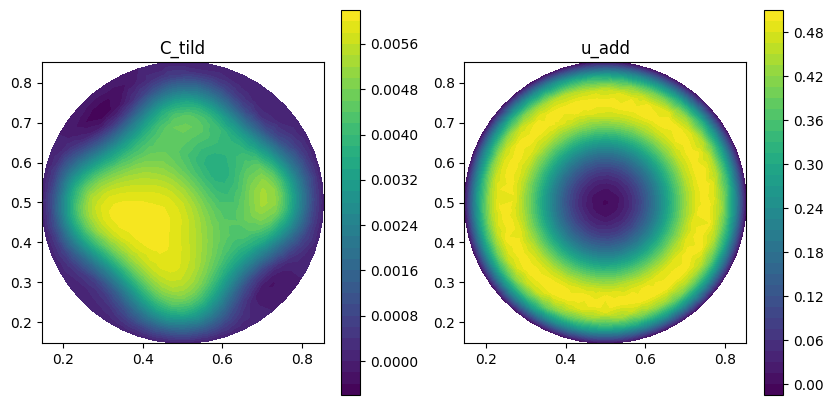

In [11]:
plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
c = plot(C)
plt.colorbar(c)
plt.title('C_tild')

plt.subplot(1,2,2)
c = plot(sol)
plt.colorbar(c)
plt.title('u_add')

## Correction $\phi$-FEM

In [12]:
from solver import *
import matplotlib.pyplot as plt

S,f,p = (0.5,1,0)
nb_vert = 32
phifem_solver = PhiFemSolver(nb_cell=nb_vert-1, params=[[S,f,p]])
solver = CorrSolver(nb_cell=nb_vert-1, params=[[S,f,p]])

num of cell in the ghost penalty: 150
num of cell in the ghost penalty: 150


In [13]:
deg_corr = 10
V_phi = FunctionSpace(solver.mesh,"CG",deg_corr)
XXYY = V_phi.tabulate_dof_coordinates()
X_test = torch.tensor(XXYY)
mu = torch.ones(XXYY.shape[0],trainer.pde.nb_parameters)*S

In [15]:
pred = trainer.network.setup_w_dict(X_test, mu)
pred
phi_tild = pred["w"][:,0].cpu().detach().numpy()
phi_tild
phi_tild_FEniCS = Function(V_phi)
phi_tild_FEniCS.vector()[np.arange(0,phi_tild.shape[0],1)] = phi_tild

self.levelset True
prior_mul <bound method Poisson2D_v2.bc_mul of <data_poisson.Poisson2D_v2 object at 0x7fdf695e70a0>>


phi_tild :


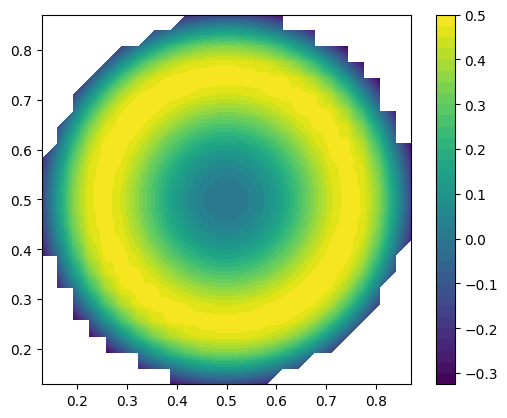

u_ex :


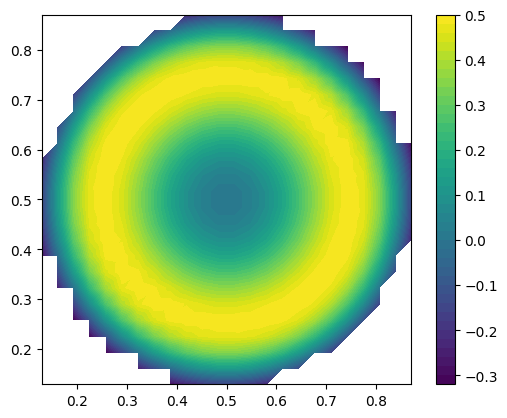

norm phi_tild :  0.00992091377037335
  Calling FFC just-in-time (JIT) compiler, this may take some time.
  Calling FFC just-in-time (JIT) compiler, this may take some time.
Solving linear variational problem.
C_tild :
Object cannot be plotted directly, projecting to piecewise linears.
  Calling FFC just-in-time (JIT) compiler, this may take some time.
  Calling FFC just-in-time (JIT) compiler, this may take some time.


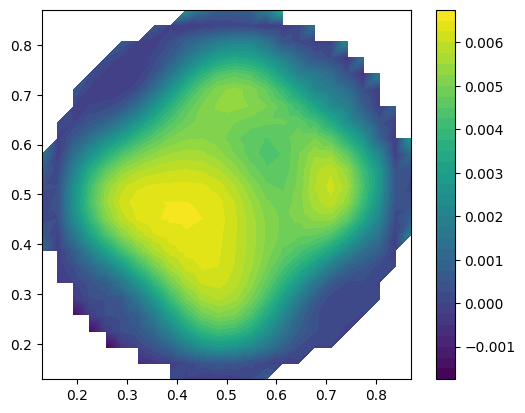

sol :
  Calling FFC just-in-time (JIT) compiler, this may take some time.
Object cannot be plotted directly, projecting to piecewise linears.


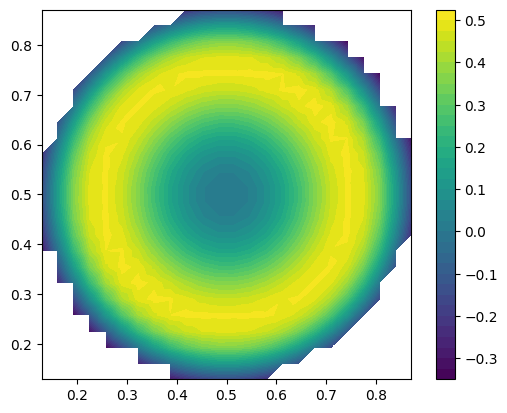

  Calling FFC just-in-time (JIT) compiler, this may take some time.
             Consider using the option 'quadrature_degree' to reduce the number of points
norm sol :  0.001461608907992942


In [17]:
sol,C,norm_L2 = solver.corr_add(0,phi_tild_FEniCS)

In [18]:
norm_L2_phifem = phifem_solver.phifem(0)
print("### Erreur Phi-FEM :", norm_L2_phifem)
print("Facteur ", norm_L2_phifem/norm_L2)

dijitso failed to load library:
	/home/lecourtier/anaconda3/envs/phifem_pytorch/.cache/dijitso/lib/libdijitso-ffc_form_f616e53a98f2d6bff3070494e989dce053e8722b.so
but dependency file exists:
	/home/lecourtier/anaconda3/envs/phifem_pytorch/.cache/dijitso/lib/libdijitso-ffc_element_47e1d8468786e24a5842fb85e0cfdb42fb1b0ced.so
error is:
	libdijitso-ffc_element_47e1d8468786e24a5842fb85e0cfdb42fb1b0ced.so: cannot open shared object file: No such file or directory


  Calling FFC just-in-time (JIT) compiler, this may take some time.


Moving new file over differing existing file:
src: /tmp/tmp9g1fv0ky/libdijitso-ffc_form_f616e53a98f2d6bff3070494e989dce053e8722b.so
dst: /home/lecourtier/anaconda3/envs/phifem_pytorch/.cache/dijitso/lib/libdijitso-ffc_form_f616e53a98f2d6bff3070494e989dce053e8722b.so
backup: /home/lecourtier/anaconda3/envs/phifem_pytorch/.cache/dijitso/lib/libdijitso-ffc_form_f616e53a98f2d6bff3070494e989dce053e8722b.so.old


Solving linear variational problem.
  Calling FFC just-in-time (JIT) compiler, this may take some time.
  Calling FFC just-in-time (JIT) compiler, this may take some time.
  Calling FFC just-in-time (JIT) compiler, this may take some time.
  Calling FFC just-in-time (JIT) compiler, this may take some time.
### Erreur Phi-FEM : 0.01838971571974329
Facteur  12.581830624579153


Object cannot be plotted directly, projecting to piecewise linears.
Object cannot be plotted directly, projecting to piecewise linears.


Text(0.5, 1.0, 'u_add')

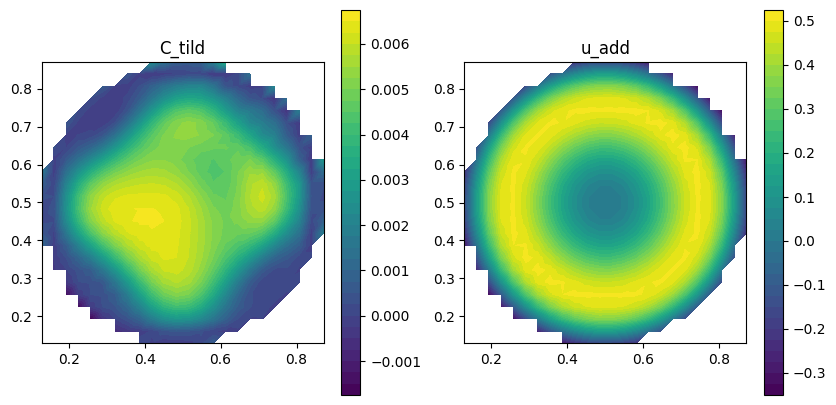

In [20]:
plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
c = plot(C)
plt.colorbar(c)
plt.title('C_tild')

plt.subplot(1,2,2)
c = plot(sol)
plt.colorbar(c)
plt.title('u_add')